In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 5.0 MB/s 
     |████████████████████████████████| 1.8 MB 27.9 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=2f5a7dfe5a8f6315fb055a62598e04258c278108a5e43170cbc52a520c2efc95
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [ ]:
import plotly.express as px
import pandas as pd
import pymc3 as pm
import numpy as np
import arviz as az

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving data.xlsx to data.xlsx


# LAB 9

In [ ]:
import io
df = pd.read_excel(io.BytesIO(uploaded['data.xlsx']))
df

,Unnamed: 0,X,Y
0,0,-0.015981,0.001984
1,1,-0.012942,-0.000511
2,2,-0.018796,0.008553
3,3,-0.019340,-0.019842
4,4,0.015664,-0.002325
...,...,...,...
95,95,0.020906,-0.005031
96,96,0.014225,0.010354
97,97,0.043465,0.033145
98,98,-0.051574,-0.033425


In [ ]:
fig = px.scatter(df, x="X", y="Y", width=800, height=800)
fig.show()

In [ ]:
def stock_loss(factual, predicted, coef=100):
    if factual * predicted < 0:
        return coef * predicted**2 + abs(factual - predicted)
    else:
        return abs(factual - predicted)

In [ ]:
X = np.asarray(df["X"].values.tolist())
Y = np.asarray(df["Y"].values.tolist())

In [ ]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)

    mean = pm.Deterministic("mean", alpha + beta * X)

    obs = pm.Normal("obs", mu=mean,sd=std,observed=Y)

    idata = pm.sample(2000, tune = 2500)

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.



In [ ]:
def stock_loss_vect(factual_vect, predicted, coef=100):
    loss_vect = np.zeros_like(factual_vect)
    ix_vect = factual_vect * predicted < 0
    loss_vect[ix_vect] = coef*predicted ** 2 + abs(factual_vect[ix_vect] - predicted)
    loss_vect[~ix_vect] = abs(factual_vect[~ix_vect] - predicted)
    return loss_vect.mean()


In [ ]:
from scipy.optimize import fmin
import matplotlib.pyplot as plt


std_samples = idata["std"]
alpha_samples = idata["alpha"]
beta_samples = idata["beta"]

N = std_samples.shape[0]

noise = std_samples * np.random.randn(N)

opt_predictions_def = np.zeros(50)
trade_signals = np.linspace(X.min(), X.max(), 50)
for i, signal in enumerate(trade_signals):
    possible_outcomes = alpha_samples + beta_samples * signal + noise
    def tomin(pred):
        return stock_loss_vect(possible_outcomes, pred)
    opt_predictions_def[i] = fmin(tomin, 0, disp=False)

opt_predictions_500 = np.zeros(50)
trade_signals = np.linspace(X.min(), X.max(), 50)
for i, signal in enumerate(trade_signals):
    possible_outcomes = alpha_samples + beta_samples * signal + noise
    def tomin(pred):
        return stock_loss_vect(possible_outcomes, pred, 500)
    opt_predictions_500[i] = fmin(tomin, 0, disp=False)

opt_predictions_1000 = np.zeros(50)
trade_signals = np.linspace(X.min(), X.max(), 50)
for i, signal in enumerate(trade_signals):
    possible_outcomes = alpha_samples + beta_samples * signal + noise
    def tomin(pred):
        return stock_loss_vect(possible_outcomes, pred, 1000)
    opt_predictions_1000[i] = fmin(tomin, 0, disp=False)
                               

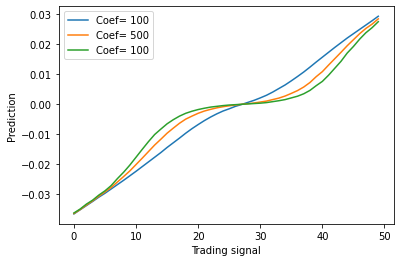

In [ ]:
plt.plot(opt_predictions_def,label = "Coef= 100")
plt.plot(opt_predictions_500,label = "Coef= 500")
plt.plot(opt_predictions_1000,label = "Coef= 100")
plt.xlabel("Trading signal")
plt.ylabel("Prediction")
plt.legend()

Zmiana czynnika coefficient wpływa na zakres ufności modelu predykcyjnego. Im wyższy tym zakres ufności zwiększa się

# LAB 10

Podejrzewam, że wydatki dzienne na około 500g jedzenie wzrosły w ciągu miesiąca

In [ ]:
days = range(30)
days

range(0, 30)

In [ ]:
food_consumption = np.random.uniform(low=450, high=500, size=(30,))
food_consumption

array([481.59916164, 462.70285993, 467.74829044, 452.23829317,
       485.33895977, 478.74772707, 463.11350327, 453.84670066,
       485.04988735, 472.49334609, 461.43876998, 487.3349154 ,
       464.83876772, 470.54088944, 462.29440984, 468.20982824,
       488.27813207, 467.11662652, 453.44879549, 468.72337003,
       472.17555566, 494.62000576, 451.50888934, 477.69243915,
       456.62877319, 487.79867086, 490.52242161, 466.20567265,
       457.23812275, 464.86586945])

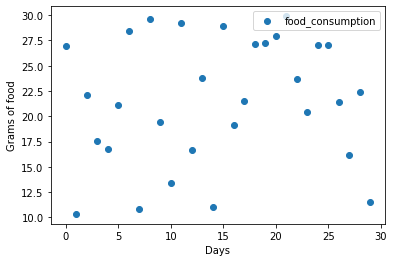

In [ ]:
plt.scatter(days, food_consumption, label = "food_consumption")
plt.xlabel("Days")
plt.ylabel("Grams of food")
plt.legend()

In [ ]:
food_price = []
for i in range(len(food_consumption)):
    if i < 13:
        food_price.append(5*food_consumption[i]/100)

    else: 
        food_price.append(8*food_consumption[i]/100)

food_price = np.asarray(food_price)
food_price

array([24.07995808, 23.135143  , 23.38741452, 22.61191466, 24.26694799,
       23.93738635, 23.15567516, 22.69233503, 24.25249437, 23.6246673 ,
       23.0719385 , 24.36674577, 23.24193839, 37.64327115, 36.98355279,
       37.45678626, 39.06225057, 37.36933012, 36.27590364, 37.4978696 ,
       37.77404445, 39.56960046, 36.12071115, 38.21539513, 36.53030186,
       39.02389367, 39.24179373, 37.29645381, 36.57904982, 37.18926956])

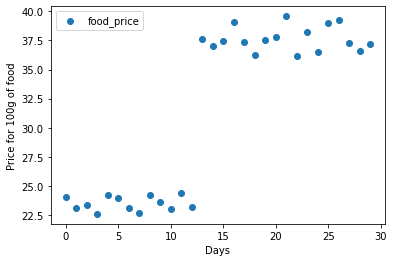

In [ ]:
plt.scatter(days, food_price, label = "food_price")
plt.xlabel("Days")
plt.ylabel("Price for 100g of food")
plt.legend()

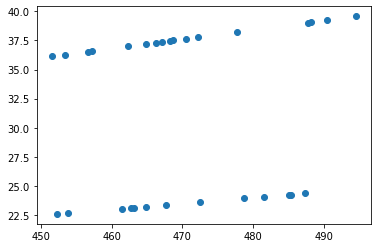

In [ ]:
plt.scatter(food_consumption, food_price)

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.



/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning:

invalid value encountered in double_scalars

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


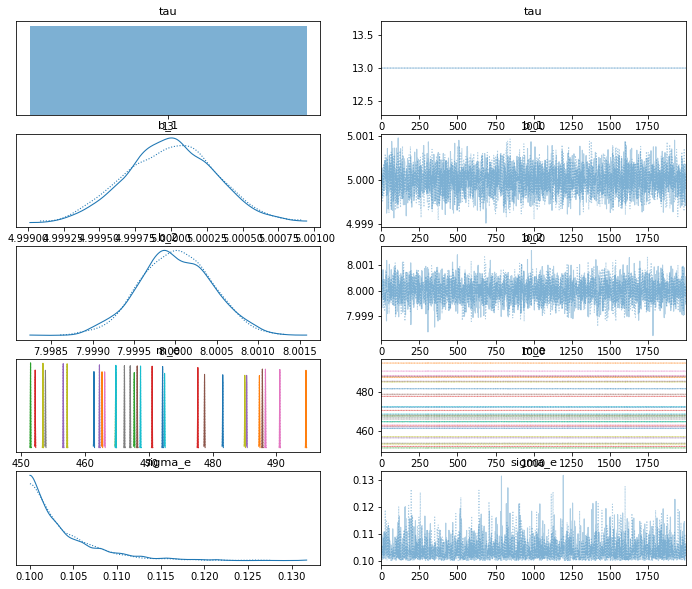

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ee25f6410>,
      dtype=object)

In [ ]:
with pm.Model() as model:
  b_1 = pm.Uniform("b_1", lower=0, upper=20)
  b_2 = pm.Uniform("b_2", lower=0, upper=20)
  tau = pm.DiscreteUniform("tau", lower=0, upper=len(food_price) - 1)
  idx = np.arange(len(food_price))
  b = pm.math.switch(tau > idx, b_1, b_2)
  m_e = pm.Deterministic("m_e", (food_price/b)*100)
  sigma_e = pm.Uniform("sigma_e", lower=0.1, upper=100)
  emission = pm.Normal("emission", mu=m_e, sigma=sigma_e, observed=food_consumption)

  idata = pm.sample(2000, tune=2500)

az.plot_trace(idata, show = True)

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.



/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning:

invalid value encountered in double_scalars

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


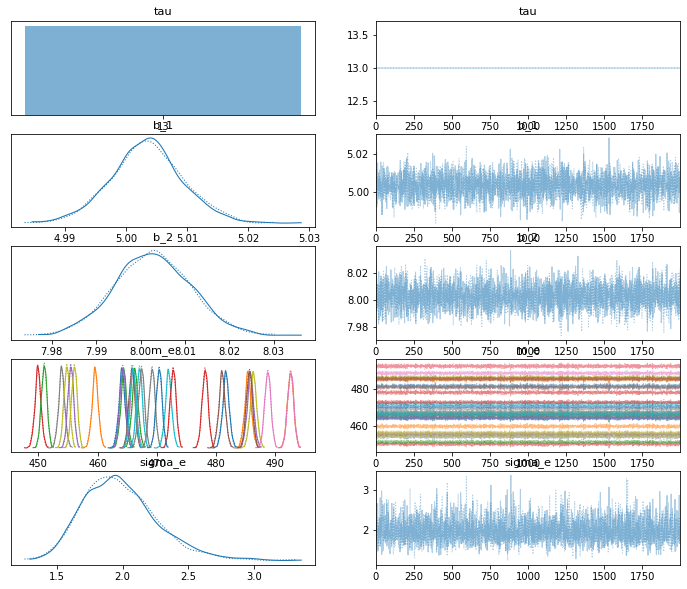

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ed6fe3610>,
      dtype=object)

In [ ]:
import random

food_price_with_noice = []
for food in food_price:
    food_price_with_noice.append(food + random.randrange(-20,20)/100)

with pm.Model() as model:
  b_1 = pm.Uniform("b_1", lower=0, upper=20)
  b_2 = pm.Uniform("b_2", lower=0, upper=20)
  tau = pm.DiscreteUniform("tau", lower=0, upper=len(food_price_with_noice) - 1)
  idx = np.arange(len(food_price_with_noice))
  b = pm.math.switch(tau > idx, b_1, b_2)
  m_e = pm.Deterministic("m_e", (food_price_with_noice/b)*100)
  sigma_e = pm.Uniform("sigma_e", lower=0.1, upper=100)
  emission = pm.Normal("emission", mu=m_e, sigma=sigma_e, observed=food_consumption)

  idata = pm.sample(2000, tune=2500)

az.plot_trace(idata, show = True)